In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [1]:
## Importing basic packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import time
import copy
import random
import os, glob, shutil
from pathlib import Path

from dataclasses import dataclass, field
from multiprocessing import Pool
import subprocess
import warnings

## For sigma masking
from astropy.stats import sigma_clip, sigma_clipped_stats

## Importing DH packages
import DH_array as dharray
import DH_path as dhpath
import DH_LegacyCrawling as dhcrawl
import DH_Galfit as dhgalfit
import DH_MC2fit as dhmc2fit
import DH_MC2fit_sub as dhmc2fitsub
import DH_masking as dhmask
import DH_masking2 as dhmask2
import DH_FileCheck as dhfc
import DH_Galfit_Sequence as dhgalseq
import DH_multicore as mulcore

## Importing drawing packages
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator
from skimage.transform import resize
import skimage

## Importing astropy packages
from astropy.modeling.functional_models import Sersic1D, Sersic2D
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval,ImageNormalize,AsinhStretch

from dataclasses import dataclass, field

This machine : SO desktop computer
LegacyCrawling - Loading summary fits south :  /home/donghyeon/ua/udg/galfit/galfit/RawData/survey-bricks-dr9-south.fits
LegacyCrawling - Loading summary fits south (DR10) :  /home/donghyeon/ua/udg/galfit/galfit/RawData/survey-bricks-dr10-south.fits
LegacyCrawling - Loading summary fits north :  /home/donghyeon/ua/udg/galfit/galfit/RawData/survey-bricks-dr9-north.fits


In [2]:
## Set to Galfit Result directory (You can make a new one)
os.chdir('./Galfit_Run/Brandon')

In [3]:
## For multi-core processing
Ncore=16

## parameters
plate_scale=0.2 #arcsec / pix

fn="./../../../coordinates/targetlist2.csv" ## CSV, list file that has RA, Dec, name ...
target=np.loadtxt(fn, skiprows=1, delimiter=',', dtype=object)
coord_array=target[:,0:2].astype(float) ## RA, Dec
name_array=target[:,2] ## Name


## Result will saved here
DI=dhfc.DirInfo('./', dir_work_base='gal_out/', ## Galfit results will be saved here
                group_rule='', use_group=False, 
                folder_rule="gal%04d/",  ## Namimg rule. 04d -> 4 digit -> up to 10000. You can change this value
                coord_array=coord_array, ## We do not need coord now
                idlist=np.arange(len(coord_array)),  ## We do not need to change it
                catalogname_list=name_array,  ## If you have catalog name, put here
               )

## Image file only
DIimg=DI.change_work_base('gal_img/', return_new=True)
print(len(DIimg.dir_work_list))

10


In [4]:
dhfc.generate_checkpixel(DIimg, Ncore=15, fna_image='image_dr9_', regionlist=['n'], silent=True)
dhfc.generate_checkpixel(DIimg, Ncore=15, fna_image='image_dr10_', regionlist=['s'], silent=True)
CheckPixels=dhfc.CheckPixel(DIimg, bad_pixel_crit=1e9)
np.where(CheckPixels.pixel_median<1)

n g
Done! | Time :  0.09679579734802246
n r
Done! | Time :  0.0853118896484375
s g
0 / 10 | Time :  0.08290505409240723
Done! | Time :  0.08793425559997559
s r
0 / 10 | Time :  0.09149289131164551
Done! | Time :  0.09635615348815918
Region - s Band - g  exist : 7
Region - s Band - r  exist : 7
Region - s Total exist : 7
Region - n Band - g  exist : 3
Region - n Band - r  exist : 4
Region - n Total exist : 3
List South : 7
List North : 1
List Bad : 2


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [5]:
DIgood=dhfc.cut_DirInfo(DI, np.invert(CheckPixels.list_bad))
len(DI.dir_work_list), len(DIgood.dir_work_list)

Previous : 10  |  New :  8


(10, 8)

# First Run (Single Sersic)

Galfit for the initial guess.

Simple Sersic fitting with central masking.

The results will be used as the initial guess parameters for the main Galfit

We will use "g-band" here.

In [6]:
# If you want to remove all Galfit data, use the command below

dhfc.multicore_remove_folder(DI.dir_work_list, Ncore=4, fna='galfit_g_base/', show_progress=1000,
                            ignore_errors=True)

0 / 10 | Time :  0.022992372512817383
Done! | Time :  0.03440141677856445


## g-band

In [6]:
MC2fitSetBase_g=dhmc2fit.Setting(plate_scale=0.262, 
                                 fni_image = 'image_lg.fits',
                                 fni_sigma = 'sigma_lg.fits', 
                                 fni_psf = 'psf_target_lg.fits',
                                 image_size = 200,
                                 est_sky=10
                          )
MC2fitSetBase_g

Setting completed


Setting(proj_folder='galfit_g_base/', fn_galfit='/home/donghyeon/galfit3.0.7b/galfit', fni_image='image_lg.fits', fni_psf='psf_target_lg.fits', fni_masking='masking_c_d.fits', fni_sigma='sigma_lg.fits', is_run_galfit_dir_work=False, band='g', est_sky=10, zeromag=22.5, plate_scale=array([0.262, 0.262]), image_size=array([200, 200]), Ncore=16, fast_skip=False, overwrite=True, remove_galfit_interval=30, debug=False, use_try=True, extract_sigma=False, output_block=True, show_progress=-1, silent=True, tolerance=0.001, comp_crit='RChi_50')

In [7]:
est_mag_list=np.arange(20, 32, 3) ## Estimaged magnitude lists (For 'sersic2', surface brightness)

##===========================================
## Smaller Reff with several different initial brightness
namelist=dharray.array_attach_string(est_mag_list, 'bs', add_at_head=True)
# Initial guess
est_params_array=np.array([[np.nan, np.nan, est_mag_list, 30, 1, np.nan, np.nan]], dtype='object')
    # index                      [  0   |  1   |      2     |  3 | 4 |  5   |  6 ]
    # params                    [ xpos | ypos |     mag     |reff| n |  ar  |  pa]
                # np.nan -> Default value as the initial guess
                #           xpos, ypos : center of the image
                #           ar, pa: 0
                # else -> use the given value as the initial guess

    ## Comp 1: Sky background
    ## Comp 2: Sersic in this case.

RunlistBase=dhmc2fit.Runlist(MC2fitSetBase_g, namelist=namelist, complist=['sersic2'],
                             est_params_array=est_params_array,
                             group_id=0, ## Fitting group
                             size_conv=101, ## Convolution box size 
                             lim_pos=np.array([[50, 150]]), ## position constraint (from - to)
                             lim_n=[[0, 5]],  ## Sersic index constraint (from - to)
                             lim_reff=np.nan, ## effective radii constraint (use None here) 
                             lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                            )
##===========================================
## Larger Reff with several different initial brightness
namelist=dharray.array_attach_string(est_mag_list, 'bl', add_at_head=True)
est_params_array=np.array([[np.nan, np.nan, est_mag_list, 90, 1, np.nan, np.nan]], dtype='object')
RunlistBase_l=dhmc2fit.Runlist(MC2fitSetBase_g, namelist=namelist, complist=['sersic2'],
                               est_params_array=est_params_array,
                               group_id=0, ## Fitting group
                               size_conv=101, ## Convolution box size 
                               lim_pos=np.array([[50, 150]]), ## position constraint (from - to)
                               lim_n=[[0, 5]],  ## Sersic index constraint (from - to)
                               lim_reff=np.nan, ## effective radii constraint (use None here) 
                               lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                              )

##===========================================
## Add to the main Runlist
RunlistBase.add_runlist(RunlistBase_l) 
RunlistBase.show_runlist() ## Show the summary

,name,complist,ncomp,est_xpos,est_ypos,est_mag,est_reff,est_n,est_ar,est_pa,lim_xpos,lim_ypos,lim_mag,lim_reff,lim_n,lim_ar,lim_pa,use_lim,group_ID
0,bs20,[sersic2],1,nan,nan,20.,30.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
1,bs23,[sersic2],1,nan,nan,23.,30.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
2,bs26,[sersic2],1,nan,nan,26.,30.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
3,bs29,[sersic2],1,nan,nan,29.,30.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
4,bl20,[sersic2],1,nan,nan,20.,90.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
5,bl23,[sersic2],1,nan,nan,23.,90.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
6,bl26,[sersic2],1,nan,nan,26.,90.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
7,bl29,[sersic2],1,nan,nan,29.,90.,1.0,nan,nan,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0


In [9]:
# ## If you want to test the code, use this

# DItest=dhfc.cut_DirInfo(DI, [0]) ## Run galfit for 1st galaxy only
# Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSet, RunlistBase, DItest,
#                       Ncore=1, debug=True, use_try=False)

In [10]:
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetBase_g, RunlistBase, DIgood, ov)

======== Multicore Briefing ========
● Multicore run for sub_run_process with Ncore 16
● Using Try (Ignoring Errors): True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.42s/it]

Done! | Time :  19.465306997299194
======== Multicore summary ========
● Succeed: 8 / 8
● Failed: 0 / 8
● Warning (w/failed): 0 / 8

======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


### Compress data

In [8]:
task=dhmc2fit.ExtractFits(MC2fitSetBase_g, DIgood)
dhfc.multicore_remove(DI.dir_work_list, fna=MC2fitSetBase_g.proj_folder+"/output*", Ncore=MC2fitSetBase_g.Ncore)

======== Multicore Briefing ========
● Multicore run for sub_run_process with Ncore 16
● Using Try (Ignoring Errors): True


100%|███████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 156.94it/s]

Done! | Time :  0.178633451461792
======== Multicore summary ========
● Succeed: 8 / 8
● Failed: 0 / 8
● Warning (w/failed): 0 / 8



0 / 10 | Time :  0.09383344650268555
Done! | Time :  0.11062860488891602


### PostProcessing

In [9]:
dhmc2fit.PostProcessing_Mulcore(MC2fitSetBase_g, RunlistBase, DIgood)

======== Multicore Briefing ========
● Multicore run for sub_run_process with Ncore 16
● Using Try (Ignoring Errors): True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.19it/s]

Done! | Time :  0.3435535430908203
======== Multicore summary ========
● Succeed: 8 / 8
● Failed: 0 / 8
● Warning (w/failed): 0 / 8



### Results

,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50
bs20,0.000000,0.000000,99.740900,100.551100,26.326100,387.184600,4.587500,13.056500,8.236722,8.236723,322640.191176,0.000000,22.941514,173362.097185,0.000000
bs23,0.000000,0.000000,99.747800,100.555800,26.747000,512.799400,4.944600,12.825500,8.229541,8.229541,322358.909926,0.000000,22.894910,173009.956560,0.000000
bs26,0.000000,0.000000,99.742600,100.552200,26.423000,413.047900,4.669900,13.003100,8.234762,8.234762,322563.378676,0.000000,22.929588,173271.987810,0.000000
bs29,0.000000,0.000000,99.747700,100.555700,26.740700,510.664500,4.939300,12.828800,8.229628,8.229627,322362.253676,0.000000,22.895410,173013.737810,0.000000
bl20,0.000000,0.000000,99.748500,100.556300,26.798300,530.691000,4.988100,12.797400,8.228881,8.228881,322333.034926,0.000000,22.890298,172975.112810,0.000000
bl23,0.000000,0.000000,99.747700,100.555700,26.743900,511.760300,4.942100,12.827000,8.229583,8.229582,322360.503676,0.000000,22.895296,173012.878435,0.000000
bl26,0.000000,0.000000,99.747600,100.555600,26.734000,508.384400,4.933700,12.832400,8.229707,8.229707,322365.378676,0.000000,22.895882,173017.300310,0.000000
bl29,0.000000,0.000000,99.747700,100.555700,26.742600,511.297500,4.940900,12.827800,8.229601,8.229601,322361.253676,0.000000,22.895313,173013.003435,0.000000


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50
bl20,0.000000,0.000000,99.748500,100.556300,26.798300,530.691000,4.988100,0.817100,15.614200,12.797400,8.228881,8.228881,322333.034926,0.000000,22.890298,172975.112810,0.000000


./gal_out/gal0000/galfit_g_base/result_bl20.fits


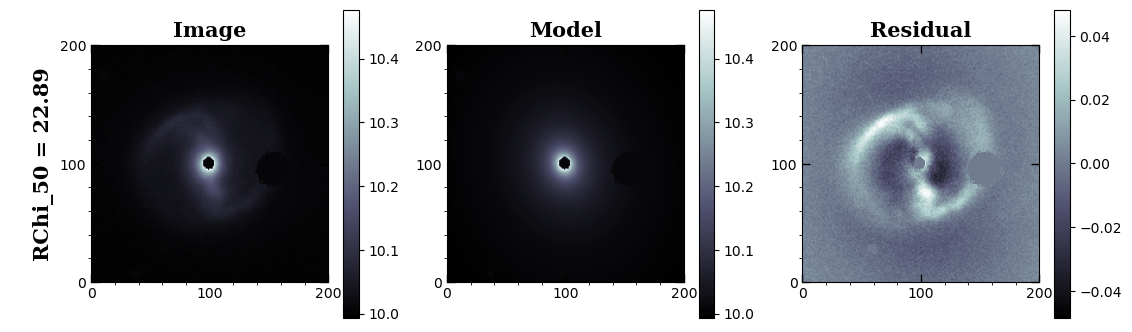

In [10]:
galid=0
ResGal=dhmc2fit.Result(MC2fitSetBase_g, RunlistBase,
                       dir_work=DIgood.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_50', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                          #  'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   
                   
                   
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)
ResGal.Data.fnlist

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

# fn=ResGal.Data.fnlist[ResGal.best[0]]
fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetBase_g, fn=fn, fn_masking=DIgood.dir_work_list[galid]+'masking_c_d.fits')

,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50
bs20,0.000000,0.000000,99.172500,101.089000,23.179600,52.945500,1.292000,14.869600,7.843674,7.843674,304358.409961,0.000000,24.026203,172716.363786,0.000000
bs23,0.000000,0.000000,99.173300,101.084800,23.181000,52.990300,1.294200,14.868600,7.843673,7.843672,304358.316211,0.000000,24.011327,172609.441911,0.000000
bs26,0.000000,0.000000,99.172600,101.088600,23.179700,52.948000,1.292200,14.869500,7.843672,7.843672,304358.316211,0.000000,24.025355,172710.270036,0.000000
bs29,0.000000,0.000000,99.173000,101.086600,23.180500,52.972500,1.293300,14.869000,7.843675,7.843675,304358.441211,0.000000,24.016784,172648.660661,0.000000
bl20,0.000000,0.000000,99.172300,101.090200,23.179100,52.930300,1.291400,14.869900,7.843672,7.843673,304358.347461,0.000000,24.031622,172755.316911,0.000000
bl23,0.000000,0.000000,99.172300,101.089900,23.179300,52.936300,1.291500,14.869800,7.843670,7.843671,304358.284961,0.000000,24.029276,172738.457536,0.000000
bl26,0.000000,0.000000,99.173200,101.085600,23.180600,52.976600,1.293700,14.868900,7.843672,7.843672,304358.316211,0.000000,24.015090,172636.488786,0.000000
bl29,0.000000,0.000000,99.172900,101.086900,23.180300,52.968300,1.293100,14.869000,7.843672,7.843672,304358.316211,0.000000,24.018203,172658.863786,0.000000


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50
bs23,0.000000,0.000000,99.173300,101.084800,23.181000,52.990300,1.294200,0.819700,19.621500,14.868600,7.843673,7.843672,304358.316211,0.000000,24.011327,172609.441911,0.000000


./gal_out/gal0000/galfit_g_base/result_bs23.fits


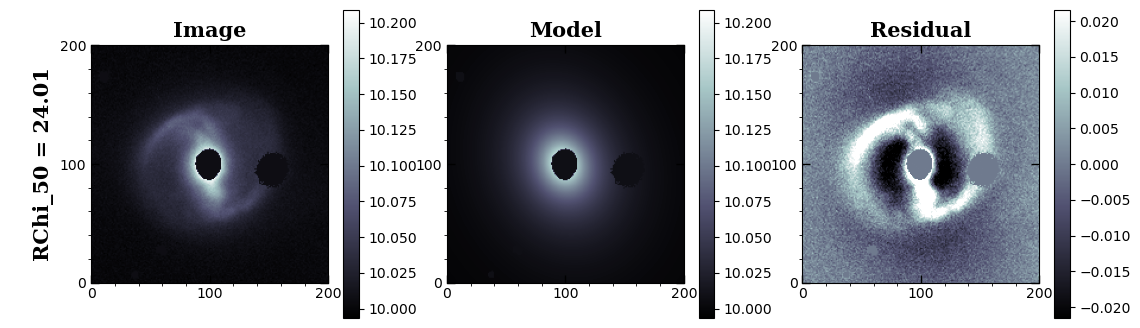

In [37]:
galid=0
ResGal=dhmc2fit.Result(MC2fitSetBase_g, RunlistBase,
                       dir_work=DIgood.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_50', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                          #  'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   
                   
                   
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)
ResGal.Data.fnlist

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

# fn=ResGal.Data.fnlist[ResGal.best[0]]
fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetBase_g, fn=fn, fn_masking=DIgood.dir_work_list[galid]+'masking_c_d.fits')

### Pack results

In [11]:
# For g-band

ResPackBase_g=dhmc2fit.ResPack(MC2fitSetBase_g, RunlistBase, DIgood)
pickle.dump(ResPackBase_g, open(DIgood.dir_base+"ResPackBase_g.pkl", "wb"))

======== Multicore Briefing ========
● Multicore run for sub_getdata with Ncore 16
● Using Try (Ignoring Errors): True


 75%|████████████████████████████████████████████████                | 6/8 [00:00<00:00, 127100.12it/s]

Done! | Time :  0.13651776313781738


In [12]:
ResPackBase_g=pickle.load(open(DI.dir_base+"ResPackBase_g.pkl", "rb"))
ResPackBase_g.preset_generate_onlyval(is_mag=False)

>> Get all submodels


## r-band

In [8]:
MC2fitSetBase_r=dhmc2fit.Setting(proj_folder='galfit_r_base/',
                                 plate_scale=0.262, 
                                 fni_image = 'image_lr.fits',
                                 fni_sigma = 'sigma_lr.fits', 
                                 fni_psf = 'psf_target_lr.fits',
                                 band = 'r',
                                 image_size = 200,
                                 est_sky=10
                          )

Setting completed


In [37]:
## Run
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetBase_r, RunlistBase, DIgood)

## Compress
task=dhmc2fit.ExtractFits(MC2fitSetBase_r, DIgood)
dhfc.multicore_remove(DIgood.dir_work_list, fna=MC2fitSetBase_r.proj_folder+"/output*", Ncore=MC2fitSetBase_r.Ncore)

## Post processing
dhmc2fit.PostProcessing_Mulcore(MC2fitSetBase_r, RunlistBase, DIgood)

# Pack
ResPackBase_r=dhmc2fit.ResPack(MC2fitSetBase_r, RunlistBase, DIgood)
pickle.dump(ResPackBase_r, open(DIgood.dir_base+"ResPackBase_r.pkl", "wb"))

Setting completed
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.30s/it]

Done! | Time :  18.501247882843018
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|███████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 181.26it/s]

Done! | Time :  0.15034747123718262
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


0 / 8 | Time :  0.09382748603820801
Done! | Time :  0.1124262809753418
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.48it/s]

Done! | Time :  0.31929850578308105
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8
Multicore run for sub_getdata with Ncore 16
show_progress :  -1
Using Try :  True



 75%|████████████████████████████████████████████████                | 6/8 [00:00<00:00, 117597.31it/s]

Done! | Time :  0.1283276081085205


In [38]:
## load
ResPackBase_r=pickle.load(open(DIgood.dir_base+"ResPackBase_r.pkl", "rb"))
ResPackBase_r.preset_generate_onlyval(is_mag=False)

>> Get all submodels


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50
bs20,0.000000,0.000000,100.624700,99.626400,21.070200,10.125900,2.429400,16.488700,1.027258,1.027258,40108.859158,0.000080,2.238882,17098.688797,0.000000
bs23,0.000000,0.000000,100.624700,99.626400,21.070700,10.128600,2.430100,16.488500,1.027259,1.027259,40108.890408,0.000080,2.238685,17097.184891,0.000000
bs26,0.000000,0.000000,100.595800,99.618600,23.359200,32.427400,5.000000,15.897300,2.882789,2.882789,112528.378690,0.000000,9.996924,76292.550125,0.000000
bs29,0.000000,0.000000,100.582800,99.607900,24.004100,47.089200,5.000000,15.720100,5.003995,5.003995,195316.909940,0.000000,20.001184,152625.050125,0.000000
bl20,0.000000,0.000000,100.196100,99.210500,29.634000,4380.569300,5.000000,11.179000,32.453260,32.453259,1266634.253690,0.000000,157.888794,1204707.518875,0.000000
bl23,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bl26,0.000000,0.000000,100.587000,99.611200,23.813000,42.135900,5.000000,15.774300,4.287038,4.287038,167334.800565,0.000000,16.587838,126581.222000,0.000000
bl29,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50
bs23,0.000000,0.000000,100.624700,99.626400,21.070700,10.128600,2.430100,0.540900,55.541300,16.488500,1.027259,1.027259,40108.890408,0.000080,2.238685,17097.184891,0.000000


./gal_out/gal0002/galfit_r_base/result_bs23.fits


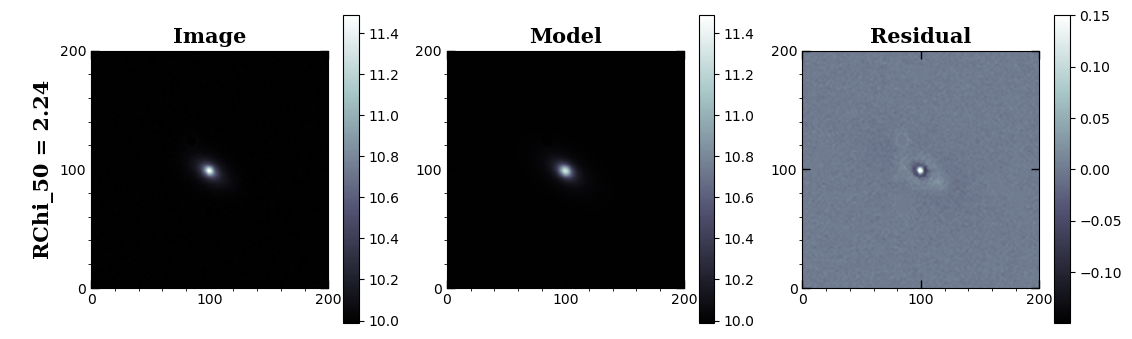

In [39]:
galid=2
ResGal=dhmc2fit.Result(MC2fitSetBase_r, RunlistBase,
                       dir_work=DIgood.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_50', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                          #  'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   
                   
                   
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)
ResGal.Data.fnlist

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetBase_g, fn=fn, fn_masking=DIgood.dir_work_list[galid]+'masking_c_d.fits')

## r-band with g-band parameters

In [18]:
# # If you want to remove all Galfit data, use the command below

dhfc.multicore_remove_folder(DI.dir_work_list, Ncore=4, fna='galfit_g_base_r/', show_progress=1000,
                            ignore_errors=True)

0 / 10 | Time :  0.022536039352416992
Done! | Time :  0.03244900703430176


In [13]:
## Setting
MC2fitSetBase_g_r=dhmc2fit.Setting(proj_folder='galfit_g_base_r/',
                                 plate_scale=0.262, 
                                 fni_image = 'image_lr.fits',
                                 fni_sigma = 'sigma_lr.fits', 
                                 fni_psf = 'psf_target_lr.fits',
                                 band = 'r',
                                 image_size = 200,
                                 est_sky=10
                                  )

Setting completed


In [14]:
RunlistForRbandBase=dhmc2fit.RunlistForBest(MC2fitSetBase_g_r, RunlistBase, ResPackBase_g)
RunlistForRbandBase.Runlist_all.show_runlist()

,name,complist,ncomp,est_xpos,est_ypos,est_mag,est_reff,est_n,est_ar,est_pa,lim_xpos,lim_ypos,lim_mag,lim_reff,lim_n,lim_ar,lim_pa,use_lim,group_ID
0,rr_0,[sersic2],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,0
1,rr_0w,[sersic2],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 5.0),(0.2 1.1),(nan nan),True,1


In [15]:
RunlistForRbandBase.run_runlist(DIgood)



Stage 0
>> Get submodels:  0
>> Group index:  0
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.94it/s]

Done! | Time :  0.38309764862060547
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 30.97it/s]

Done! | Time :  0.3504514694213867
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


In [16]:
## Compress
task=dhmc2fit.ExtractFits(MC2fitSetBase_g_r, DIgood)
dhfc.multicore_remove(DIgood.dir_work_list, fna=MC2fitSetBase_g_r.proj_folder+"/output*", Ncore=MC2fitSetBase_g_r.Ncore)

## Post processing
dhmc2fit.PostProcessing_Mulcore(MC2fitSetBase_g_r, RunlistForRbandBase.Runlist_all, DIgood)

# Pack
ResPackBase_g_r=dhmc2fit.ResPack(MC2fitSetBase_g_r, RunlistForRbandBase.Runlist_all, DIgood)
pickle.dump(ResPackBase_g_r, open(DIgood.dir_base+"ResPackBase_g_r.pkl", "wb"))


Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|███████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 362.18it/s]

Done! | Time :  0.11263871192932129
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


0 / 8 | Time :  0.07528948783874512
Done! | Time :  0.09266066551208496
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|███████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 100.41it/s]

Done! | Time :  0.1664867401123047
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8
Multicore run for sub_getdata with Ncore 16
show_progress :  -1
Using Try :  True



 75%|████████████████████████████████████████████████                | 6/8 [00:00<00:00, 109894.43it/s]

Done! | Time :  0.09612131118774414


# Second Runlist - Main

Main Galfit based on the Runlist-base

Now we will use the 'normal masking image' instead of the 'additional central mask' image.

In [19]:
ResPackBase_g=pickle.load(open(DI.dir_base+"ResPackBase_g.pkl", "rb"))
ResPackBase_g.preset_generate_onlyval(is_mag=False)

>> Get all submodels


In [77]:
# If you want to remove all Galfit data, use the command below

dhfc.multicore_remove_folder(DI.dir_work_list, Ncore=4, fna='galfit_g_main/', show_progress=1000,
                            ignore_errors=True)

0 / 10 | Time :  0.02464461326599121
Done! | Time :  0.03551149368286133


In [78]:
MC2fitSetMain_g=dhmc2fit.Setting(proj_folder='galfit_g_main/',
                                 plate_scale=0.262, 
                                 fni_image = 'image_lg.fits',
                                 fni_sigma = 'sigma_lg.fits', 
                                 fni_psf = 'psf_target_lg.fits',
                                 fni_masking='masking_c.fits',
                                 image_size = 200,
                                 est_sky=10
                          )
MC2fitSetMain_g

Setting completed


Setting(proj_folder='galfit_g_main/', fn_galfit='/home/donghyeon/galfit3.0.7b/galfit', fni_image='image_lg.fits', fni_psf='psf_target_lg.fits', fni_masking='masking_c.fits', fni_sigma='sigma_lg.fits', is_run_galfit_dir_work=False, band='g', est_sky=10, zeromag=22.5, plate_scale=array([0.262, 0.262]), image_size=array([200, 200]), Ncore=16, fast_skip=False, overwrite=True, remove_galfit_interval=30, debug=False, use_try=True, extract_sigma=False, output_block=True, show_progress=-1, silent=True, tolerance=0.001, comp_crit='RChi_50')

In [79]:
## The result of the first run will be used as initial guess of the second run

est_mag_list=np.array([0]) ## No mag changes

##===========================================
## Simple Sersic (Group 0)
namelist=dharray.array_attach_string(est_mag_list, 'rs_', add_at_head=True)
# Initial guess
est_params_array=np.array([[0, 0, est_mag_list, 0, 0, 0, 0]],  ## This will be added --> All values = 0 except for est_mag.
                          dtype='object') 
    # index                      [  0   |  1   |      2     |  3 | 4 |  5   |  6 ]
    # params                    [ xpos | ypos |     mag     |reff| n |  ar  |  pa]
                # np.nan -> Default value as the initial guess
                #           xpos, ypos : center of the image
                #           ar, pa: 0
                # else -> use the given value as the initial guess

    ## Comp 1: Sky background
    ## Comp 2: Sersic in this case.

RunlistMain_sim=dhmc2fit.Runlist(MC2fitSetMain_g, namelist=namelist, complist=['sersic2'],
                             est_params_array=est_params_array,
                             group_id=0, ## Fitting group
                             size_conv=101, ## Convolution box size 
                             lim_pos=np.array([[50, 150]]), ## position constraint (from - to)
                             lim_n=[[0, 10]],  ## Sersic index constraint (from - to)
                             lim_reff=np.nan, ## effective radii constraint (use None here) 
                             lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                            )
        
##===========================================
## Double Sersics (Group 1) 
namelist=dharray.array_attach_string(est_mag_list, 'rss_', add_at_head=True)
est_params_array=np.array([[0, 0, est_mag_list, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                           [0, 0, 0, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                          dtype='object') 

RunlistMain_sim_add=dhmc2fit.Runlist(MC2fitSetMain_g, namelist=namelist, complist=['sersic2','sersic2'],
                                 est_params_array=est_params_array,
                                 group_id=1, ## Fitting group
                                 size_conv=101, ## Convolution box size 
                                 lim_pos=np.array([[50, 150]]), ## position constraint (from - to)
                                 lim_n=[[0, 2], [0.1, 10]],  ## Sersic index constraint (from - to)
                                 lim_reff=np.nan, ## effective radii constraint (use None here) 
                                 lim_ar=[[0.2, 1.1], [0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )
                             
RunlistMain_sim.add_runlist(RunlistMain_sim_add)


##===========================================
## Sersic + PSF (Group 2)
namelist=dharray.array_attach_string(est_mag_list, 'rspsf_', add_at_head=True)
est_params_array=np.array([[0, 0, est_mag_list, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                           [0, 0, 0, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                          dtype='object') 

RunlistMain_sim_add=dhmc2fit.Runlist(MC2fitSetMain_g, namelist=namelist, complist=['sersic2','psf'],
                                 est_params_array=est_params_array,
                                 group_id=2, ## Fitting group
                                 size_conv=101, ## Convolution box size 
                                 lim_pos=np.array([[50, 150]]), ## position constraint (from - to)
                                 lim_n=[[0, 10]],  ## Sersic index constraint (from - to)
                                 lim_reff=np.nan, ## effective radii constraint (use None here) 
                                 lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )

RunlistMain_sim.add_runlist(RunlistMain_sim_add)



In [80]:
##================== Extended version ========================
## Variation in their magnitude
est_mag_list2=np.arange(-6, 4, 3)  ## Comp3 variation
est_mag_list2=est_mag_list2[est_mag_list2!=0]
offsets=np.arange(-3, 4, 3) ## Comp offset
firstname=['b', '0', 'd']


for i, offset in enumerate(offsets):
    ## Double Sersic
    namelist=dharray.array_attach_string(est_mag_list2, 'rss_'+str(firstname[i])+"_", add_at_head=True)
    est_params_array=np.array([[0, 0, offset, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                               [np.nan, np.nan, est_mag_list2, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                              dtype='object') 
    RunlistMain_sim_add=dhgalfit.Runlist_Galfit(namelist=namelist, complist=['sersic2','sersic2'],
                                            est_params_array=est_params_array,
                                            group_id=1,  
                                            size_conv=101,
                                            use_constraint_list=True, 
                                            lim_pos=np.array([[50, 150]]),
                                            lim_n=[[0, 2], [0.1, 10]], 
                                            lim_reff=None,
                                            lim_ar=[[0.2, 1.1], [0.3, 1.1]],
                                            )
    RunlistMain_sim.add_runlist(RunlistMain_sim_add)

    ##===========================================
    ## Sersic + PSF (Group 2)
    namelist=dharray.array_attach_string(est_mag_list2, 'rspsf_'+str(firstname[i])+"_", add_at_head=True)
    est_params_array=np.array([[0, 0, offset, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                               [0, 0, est_mag_list2, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                              dtype='object') 
    
    
    RunlistMain_sim_add=dhmc2fit.Runlist(MC2fitSetMain_g, namelist=namelist, complist=['sersic2','psf'],
                                     est_params_array=est_params_array,
                                     group_id=2, ## Fitting group
                                     size_conv=101, ## Convolution box size 
                                     lim_pos=np.array([[50, 150]]), ## position constraint (from - to)
                                     lim_n=[[0, 2], [0.1, 10]],  ## Sersic index constraint (from - to)
                                     lim_reff=np.nan, ## effective radii constraint (use None here) 
                                     lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )
                             
    RunlistMain_sim.add_runlist(RunlistMain_sim_add)
    
    
    
# namelist=dharray.array_attach_string(est_mag_list, 'rpsf_', add_at_head=True)
# est_params_array=np.array([[np.nan, np.nan, est_mag_list, 5, 3, np.nan, np.nan]],  
#                           dtype='object') 
# Runlist_2nd_add=dhgalfit.Runlist_Galfit(namelist=namelist, complist=['psf'],
#                                         est_params_array=est_params_array,
#                                         group_id=3, size_conv=101,
#                                         use_constraint_list=True, 
#                                         lim_pos=np.array([[400, 600]]),
#                                         lim_n=None, 
#                                         lim_reff=None,
#                                         lim_ar=[[0.2, 1.1], [0.3, 1.1]],
#                                         )


# Runlist_2nd.add_runlist(Runlist_2nd_add)
## In this case, est_n2, est_reff2 is not used.

In [81]:
RunlistMain=copy.deepcopy(RunlistMain_sim)
RunlistMain_pos=copy.deepcopy(RunlistMain_sim)
RunlistMain_pos.runlist=RunlistMain_pos.runlist[(RunlistMain_pos.runlist['group_ID']==1) | (RunlistMain_pos.runlist['group_ID']==2)]
for i, text in enumerate(RunlistMain_pos.runlist['name']):
    newtext=text.split("_")
    newtext[0]=newtext[0]+"p"
    RunlistMain_pos.runlist['name'][i]='_'.join(newtext)
    
RunlistMain.add_runlist(RunlistMain_pos)
# Runlist_2nd_all.add_runlist(Runlist_2nd_2)
# Runlist_2nd_all.add_runlist(Runlist_2nd_psf)

In [82]:
RunlistMain.show_runlist()

,name,complist,ncomp,est_xpos,est_ypos,est_mag,est_reff,est_n,est_ar,est_pa,lim_xpos,lim_ypos,lim_mag,lim_reff,lim_n,lim_ar,lim_pa,use_lim,group_ID
0,rs_0,[sersic2],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(50.0 150.0),(50.0 150.0),(nan nan),(nan nan),(0.0 10.0),(0.2 1.1),(nan nan),True,0
1,rss_0,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,1
2,rspsf_0,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 10.0), (0.0 10.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
3,rss_b_-6,"[sersic2, sersic2]",2,"0.0, nan","0.0, nan","-3.0, -6","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.3 1.1)","(nan nan), (nan nan)",True,1
4,rss_b_-3,"[sersic2, sersic2]",2,"0.0, nan","0.0, nan","-3.0, -3","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.3 1.1)","(nan nan), (nan nan)",True,1
5,rss_b_3,"[sersic2, sersic2]",2,"0.0, nan","0.0, nan","-3.0, 3.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.3 1.1)","(nan nan), (nan nan)",True,1
6,rspsf_b_-6,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","-3.0, -6","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
7,rspsf_b_-3,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","-3.0, -3","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
8,rspsf_b_3,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","-3.0, 3.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
9,rss_0_-6,"[sersic2, sersic2]",2,"0.0, nan","0.0, nan","0.0, -6.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(50.0 150.0), (50.0 150.0)","(50.0 150.0), (50.0 150.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 10.0)","(0.2 1.1), (0.3 1.1)","(nan nan), (nan nan)",True,1


## find additional starting point (masked region)

In [83]:
maskpos=np.full((len(DIgood.dir_work_list), 2), np.nan)
for i in range (len(DIgood.dir_work_list)):
    if(i%1000==0): print(i)
    maskdat=np.load(DIgood.dir_work_list[i]+'maskobj_r.npy')

    try:
        maskdat=maskdat[(maskdat['x']>75) & (maskdat['y']>75) & (maskdat['x']<175) & (maskdat['y']<175)]
        dist=((maskdat['x']-100)**2+(maskdat['y']-100)**2)**0.5
        maskdat=maskdat[dist>3] ## offset
        
        thismask=maskdat[maskdat['flux']==np.nanmax(maskdat['flux'])][0]
        maskpos[i]=thismask['x'], thismask['y']
    except: pass

0


## g-band

### Galfit Run

In [84]:
UseRes=ResPackBase_g.params_array ## Shape: N_Target(DI), Comp, item (7)

UseRes_fixed_pos=np.copy(UseRes)
UseRes_fixed_pos[:,1,:]=0 ## reset the values 
UseRes_fixed_pos[:,1,0]=UseRes_fixed_pos[:,0,0] 
UseRes_fixed_pos[:,1,1]=UseRes_fixed_pos[:,0,1] 

In [85]:
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_g, RunlistMain_sim, DIgood, 
                               Ncomp_add_params_array=2, ## We will use up to 2 comp
                               add_params_array_set=UseRes_fixed_pos,  ## Measured params array
                               is_nth_mag_offset=True, 
                              )

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [01:04<00:00,  8.04s/it]

Done! | Time :  64.39668488502502
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


### Galfit additional Run

In [86]:
UseRes_2nd_pos=np.copy(UseRes)
for i in range(len(UseRes_2nd_pos)):
    UseRes_2nd_pos[i,1,0]=maskpos[i,0] ## X
    UseRes_2nd_pos[i,1,1]=maskpos[i,1] ## Y
    UseRes_2nd_pos[i,1,2]=0 ## Offset
    
# newshape=np.array(np.shape(UseRes))
# newshape[1]+=1
# UseRes_2nd_2=np.full(newshape, np.nan)
# UseRes_2nd_2[:,0]=np.copy(UseRes[:,0])
# UseRes_2nd_2[:,2]=np.copy(UseRes_2nd_pos[:,1])
# for i in range(len(UseRes_2nd_2)):
#     UseRes_2nd_2[i,1,2]=0 ## Mag Offset
    
# newshape=np.array(np.shape(UseRes))
# newshape[1]+=-1
# UseRes_2nd_psfp=np.full(newshape, np.nan)
# UseRes_2nd_psfp[:,0]=np.copy(UseRes_2nd_pos[:,1])
# UseRes_2nd_psfp[:,0,2]=np.copy(UseRes_2nd_pos[:,0,2])

In [87]:
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_g, RunlistMain_pos, DIgood, 
                               Ncomp_add_params_array=2, ## We will use up to 2 comp
                               add_params_array_set=UseRes_2nd_pos,  ## Measured params array
                               is_nth_mag_offset=True, 
                              )

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:48<00:00,  6.10s/it]

Done! | Time :  48.86669206619263
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


### Compress data

In [88]:
task=dhmc2fit.ExtractFits(MC2fitSetMain_g, DIgood)
dhfc.multicore_remove(DIgood.dir_work_list, fna=MC2fitSetMain_g.proj_folder+"/output*", Ncore=MC2fitSetMain_g.Ncore)

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 55.32it/s]

Done! | Time :  0.2446742057800293
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


0 / 8 | Time :  0.08958029747009277
Done! | Time :  0.1065216064453125


### Postprocessing

In [89]:
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_g, RunlistMain, DIgood)

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.37it/s]

Done! | Time :  1.057978868484497
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


#### Calculate AIC within Re

In [90]:
def rad_list(original_array, minre=40):
    usinglist=np.copy(original_array)
    usinglist[np.isnan(usinglist)]=minre
    usinglist[usinglist<minre]=minre # Prevent to small Re
    return usinglist


minre=20 ## Minimum effective radius

# Base Sersic - r band (Based on AIC_50)
radius_list_base_g=rad_list(ResPackBase_g.bob_onlyval['2_RE'], minre) 
radius_list_base_gw=rad_list(ResPackBase_g.bobwarn_onlyval['2_RE'], minre) 

chi_radius_array=np.vstack((radius_list_base_g/2, radius_list_base_g,
                           )).T
chi_item_name_array=['hRb', 'Rb']

In [91]:
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_g, RunlistMain, DIgood,
                               chi2_radius_array_set=chi_radius_array,
                               chi_item_namelist=chi_item_name_array)

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]

Done! | Time :  1.0411567687988281
======== Multicore result ========
● Succeed: 8 / 8
● Failed: 0 / 8


### Result

In [92]:
radius_list_base_g

array([52.9903, 23.3969, 20.    , 20.    , 20.    , 20.    , 20.    ,
       20.    ])

,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,3_XC,3_YC,3_MU_E,3_RE,3_N,3_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,101.280200,100.586700,25.490900,11.887100,10.000000,19.616600,nan,nan,nan,nan,nan,nan,0.770177,0.770176,30268.534916,1.000000,0.972921,7580.477508,0.955294,2719.131254,0.000000,1799.900028,0.000000
rss_0,1.000000,0.000000,101.289600,100.587400,25.746300,16.147500,2.000000,20.010900,101.289600,100.587400,25.746300,5.000000,3.000000,21.921400,0.893503,1.204076,47317.703629,0.000000,3.175403,24696.595003,0.000000,19435.138738,0.000000,17481.606403,0.000000
rspsf_0,2.000000,0.000000,101.738400,99.952400,24.828900,7.646500,0.880100,21.226600,101.190400,100.673900,nan,nan,nan,20.887000,0.728302,0.728302,28627.534065,1.000000,0.773027,6029.996863,1.000000,1333.013318,0.098602,620.549168,0.000000
rss_b_-6,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rss_b_-3,1.000000,0.000000,101.274900,100.339500,23.741100,2.638200,2.000000,23.203200,101.273600,100.606400,22.308800,2.308600,10.000000,20.201600,0.731786,0.731786,28769.441910,1.000000,0.789550,6163.282991,1.000000,1437.167180,0.000727,730.636799,0.000000
rss_b_3,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rspsf_b_-6,2.000000,0.000000,101.740700,99.963500,24.847200,7.714300,0.836300,21.238000,101.193200,100.669200,nan,nan,nan,20.879500,0.728297,0.728297,28627.328987,1.000000,0.773000,6029.792273,1.000000,1333.241345,0.097837,621.073460,0.000000
rspsf_b_-3,2.000000,0.000000,101.740900,99.966100,24.848600,7.708100,0.840900,21.237000,101.192900,100.669200,nan,nan,nan,20.879800,0.728297,0.728297,28627.332894,1.000000,0.773001,6029.796668,1.000000,1333.191785,0.098003,621.407993,0.000000
rspsf_b_3,2.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rss_0_-6,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,3_XC,3_YC,3_MU_E,3_RE,3_N,3_AR,3_PA,3_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,101.280200,100.586700,25.490900,11.887100,10.000000,0.650400,19.595800,19.616600,nan,nan,nan,nan,nan,nan,nan,nan,0.770177,0.770176,30268.534916,1.000000,0.972921,7580.477508,0.955294,2719.131254,0.000000,1799.900028,0.000000
rss_b_-3,1.000000,0.000000,101.274900,100.339500,23.741100,2.638200,2.000000,0.210600,0.536400,23.203200,101.273600,100.606400,22.308800,2.308600,10.000000,0.536800,21.258800,20.201600,0.731786,0.731786,28769.441910,1.000000,0.789550,6163.282991,1.000000,1437.167180,0.000727,730.636799,0.000000
rspsf_d_-6,2.000000,0.000000,101.739700,99.942300,24.830000,7.651700,0.882800,0.606700,16.862500,21.226500,101.190500,100.674800,nan,nan,nan,nan,nan,20.887100,0.728302,0.728302,28627.532112,1.000000,0.773026,6029.994910,1.000000,1332.973035,0.098738,620.258152,0.000000


./gal_out/gal0009/galfit_g_main/result_rspsf_d_-6.fits


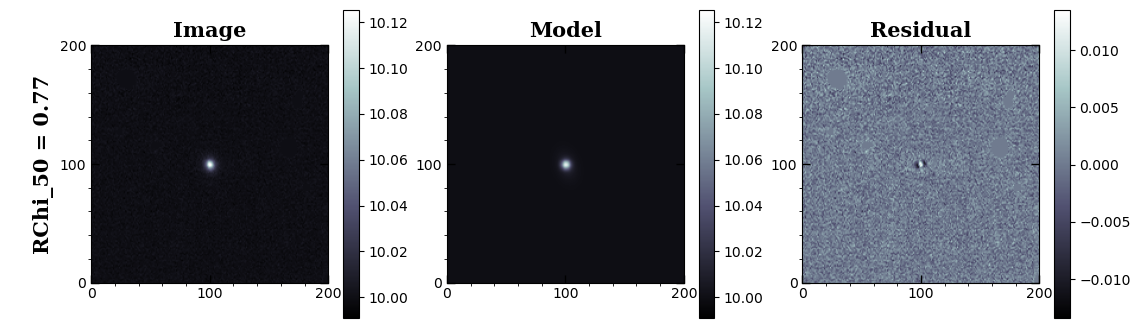

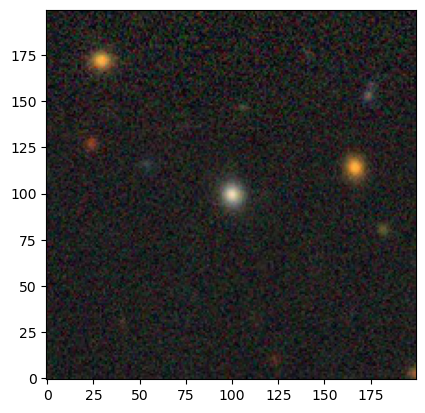

In [99]:
galid=7
ResGal=dhmc2fit.Result(MC2fitSetMain_g, RunlistMain,
                       dir_work=DIgood.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_Rb', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                    'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   
                   
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)
ResGal.Data.fnlist

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetMain_g, fn=fn, fn_masking=DIgood.dir_work_list[galid]+'masking_c.fits')
plt.show()

image_filename = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra='+str(DIgood.coord_array[galid][0])+'&dec='+str(DIgood.coord_array[galid][1])+'&size=200&layer=ls-dr9'
#print(image_filename)
plt.imshow(skimage.io.imread( image_filename )[::-1], origin='lower')
plt.show()

In [43]:
dhmc2fit.Drawing?

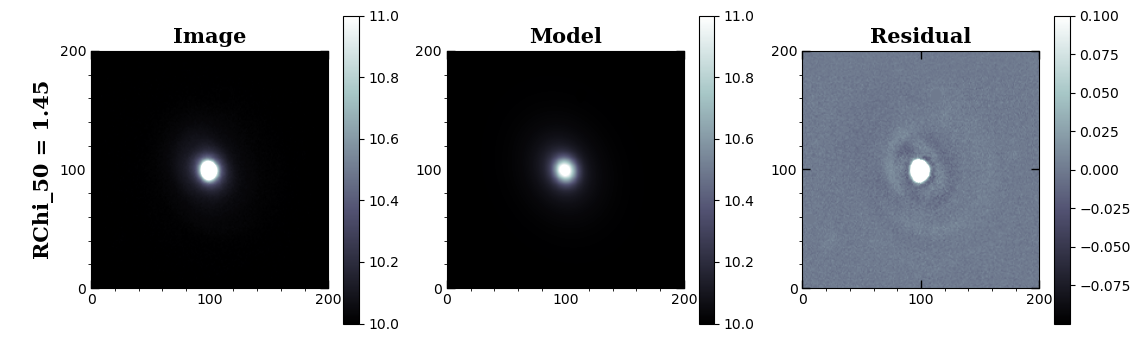

In [49]:
img=dhmc2fit.Drawing(MC2fitSetMain_g, fn=fn, fn_masking=DIgood.dir_work_list[galid]+'masking_c.fits',
                    vmax=11, vmin=10)
plt.show()


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,3_XC,3_YC,3_MU_E,3_RE,3_N,3_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,100.290000,101.278100,22.512300,11.988300,3.259200,16.992000,nan,nan,nan,nan,nan,nan,0.810389,0.810389,32143.863007,1.000000,1.346254,10566.610174,0.000000,4716.443998,0.000000,3515.058109,0.000000
rss_0,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rspsf_0,2.000000,0.000000,100.203400,101.120500,22.376400,11.755400,1.620000,17.262300,100.381700,101.507700,nan,nan,nan,19.518900,0.709706,0.709706,28156.190254,1.000000,0.885006,6955.169446,1.000000,1876.041272,0.000000,1188.629734,0.000000
rss_b_-3,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rss_b_3,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rspsf_b_-3,2.000000,0.000000,100.203300,101.120300,22.376300,11.754300,1.619900,17.262300,100.382000,101.508000,nan,nan,nan,19.518900,0.709705,0.709706,28156.153144,1.000000,0.885007,6955.176282,1.000000,1875.143689,0.000000,1187.651096,0.000000
rspsf_b_3,2.000000,0.000000,100.203300,101.120300,22.376300,11.754300,1.619900,17.262300,100.382000,101.508000,nan,nan,nan,19.518900,0.709705,0.709706,28156.153144,1.000000,0.885007,6955.176282,1.000000,1875.143689,0.000000,1187.651096,0.000000
rss_0_-3,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rss_0_3,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rspsf_0_-3,2.000000,0.000000,100.204200,101.118800,22.375700,11.751500,1.616700,17.263200,100.380200,101.509300,nan,nan,nan,19.516600,0.709697,0.709697,28155.826972,1.000000,0.885026,6955.329114,1.000000,1874.351697,0.000000,1185.870945,0.000000


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,3_XC,3_YC,3_MU_E,3_RE,3_N,3_AR,3_PA,3_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,100.290000,101.278100,22.512300,11.988300,3.259200,0.796900,-55.993700,16.992000,nan,nan,nan,nan,nan,nan,nan,nan,0.810389,0.810389,32143.863007,1.000000,1.346254,10566.610174,0.000000,4716.443998,0.000000,3515.058109,0.000000
rssp_0,1.000000,0.000000,100.095100,101.012200,22.766400,13.065500,1.147300,0.718500,-69.604500,17.695200,100.345900,101.404600,23.079400,8.339100,10.000000,0.685400,-18.037000,17.918000,0.701610,0.701610,27840.435938,1.000000,0.845460,6650.012482,1.000000,1743.076238,0.000000,1027.912433,0.000000
rspsf_0_-3,2.000000,0.000000,100.204200,101.118800,22.375700,11.751500,1.616700,0.791200,-57.315500,17.263200,100.380200,101.509300,nan,nan,nan,nan,nan,19.516600,0.709697,0.709697,28155.826972,1.000000,0.885026,6955.329114,1.000000,1874.351697,0.000000,1185.870945,0.000000


./gal_out/gal0003/galfit_g_main/result_rssp_0.fits


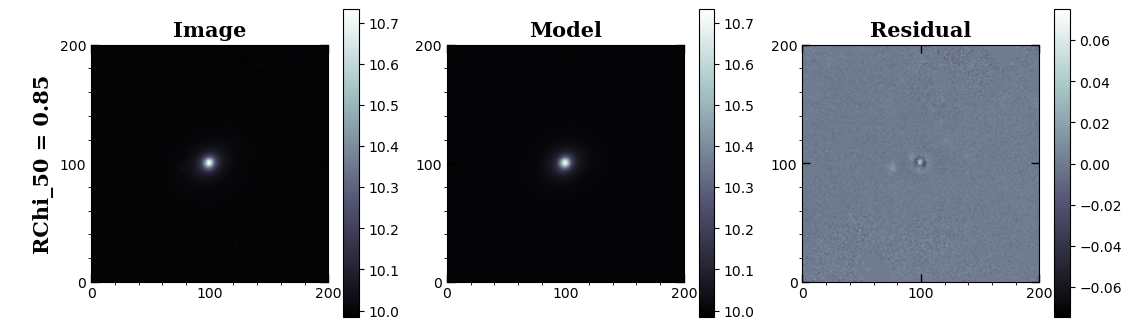

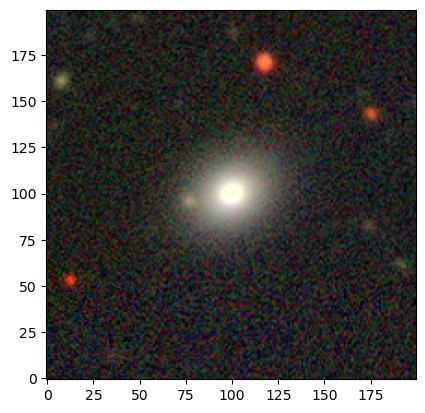

In [134]:
galid=3
ResGal=dhmc2fit.Result(MC2fitSetMain_g, RunlistMain,
                       dir_work=DIgood.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_hRb', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                    'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   
                   
                   
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)
ResGal.Data.fnlist

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetMain_g, fn=fn, fn_masking=DIgood.dir_work_list[galid]+'masking_c.fits')
plt.show()

image_filename = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra='+str(DIgood.coord_array[galid][0])+'&dec='+str(DIgood.coord_array[galid][1])+'&size=200&layer=ls-dr9'
#print(image_filename)
plt.imshow(skimage.io.imread( image_filename )[::-1], origin='lower')
plt.show()

### Pack

In [43]:
# For g-band

ResPackMain_g=dhmc2fit.ResPack(MC2fitSetMain_g, RunlistMain, DI, 
                               chi2_itemlist=['CHI2NU', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50', 
                                              'AIC_hRb', 'LIK_hRb', 'AIC_Rb', 'LIK_Rb', 
                                             ],
                               comp_crit='AIC_hRb', )
pickle.dump(ResPackMain_g, open(DI.dir_base+"ResPackMain_g.pkl", "wb"))

Multicore run for sub_getdata with Ncore 16
show_progress :  -1
Using Try :  True


6it [00:00, 93206.76it/s]                                               

Done! | Time :  0.1454932689666748


In [60]:
ResPackMain_g=pickle.load(open(DI.dir_base+"ResPackMain_g.pkl", "rb"))
ResPackMain_g.preset_generate_onlyval(is_mag=False)

>> Get all submodels


## r-band

In [33]:
# If you want to remove all Galfit data, use the command below

dhfc.multicore_remove_folder(DI.dir_work_list, Ncore=4, fna='galfit_r_main/', show_progress=1000,
                            ignore_errors=True)

0 / 9 | Time :  0.04438447952270508
Done! | Time :  0.06922793388366699


In [46]:
## Setting
MC2fitSetMain_r=dhmc2fit.Setting(plate_scale=0.2, 
                                 zeromag=0,
                                 proj_folder='galfit_r_main/',
                                 fni_image='image_r.fits',
                                 fni_sigma='sigma_r.fits',
                                 fni_psf='psf_r.fits',
                                 band='r',
                                )

## Run
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_r, RunlistMain_sim, DI, 
                               Ncomp_add_params_array=2, ## We will use up to 2 comp
                               add_params_array_set=UseRes_fixed_pos,  ## Measured params array
                               is_nth_mag_offset=True, 
                              )

Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_r, RunlistMain_pos, DI, 
                               Ncomp_add_params_array=2, ## We will use up to 2 comp
                               add_params_array_set=UseRes_2nd_pos,  ## Measured params array
                               is_nth_mag_offset=True, 
                              )


## Compress
task=dhmc2fit.ExtractFits(MC2fitSetMain_r, DI)
dhfc.multicore_remove(DI.dir_work_list, fna=MC2fitSetMain_r.proj_folder+"/output*", Ncore=MC2fitSetMain_r.Ncore)

## Post processing
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_r, RunlistMain, DI)
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_r, RunlistMain, DI,
                               chi2_radius_array_set=chi_radius_array,
                               chi_item_namelist=chi_item_name_array)

# Pack
ResPackMain_r=dhmc2fit.ResPack(MC2fitSetMain_r, RunlistMain, DI)
pickle.dump(ResPackMain_r, open(DI.dir_base+"ResPackMain_r.pkl", "wb"))

Setting completed
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [00:45<00:00, 15.23s/it]

Done! | Time :  45.81803917884827
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:25<00:00,  8.51s/it]

Done! | Time :  25.734301328659058
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:00<00:00, 62.51it/s]

Done! | Time :  0.1468508243560791
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


0 / 3 | Time :  0.09638142585754395
Done! | Time :  0.11434388160705566
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [00:00<00:00,  5.43it/s]

Done! | Time :  0.6541898250579834
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:00<00:00,  6.55it/s]

Done! | Time :  0.5593693256378174
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_getdata with Ncore 16
show_progress :  -1
Using Try :  True



6it [00:00, 102717.65it/s]                                              

Done! | Time :  0.15304827690124512


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,3_XC,3_YC,3_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,250.519200,251.624500,34.794500,22.413500,0.726800,29.412500,nan,nan,nan,1.134599,1.134599,269854.224779,0.000000,1.385974,10764.244759,0.000000,2681.552158,0.000000,496.015547,0.000000
rss_0,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rspsf_0,2.000000,0.000000,250.545500,251.622500,34.794500,22.414300,0.724500,29.413100,239.517100,251.037400,38.701800,1.134601,1.134601,269857.412910,0.000000,1.385673,10763.774425,0.000000,2688.930988,0.000000,502.213975,0.000000
rspsf_b_-3,2.000000,0.000000,250.547600,251.625000,34.794600,22.416800,0.723400,29.413600,240.177100,251.154900,38.265400,1.134592,1.134592,269855.242557,0.000000,1.385172,10759.887464,0.000000,2686.683746,0.000000,500.094324,0.000000
rspsf_b_3,2.000000,0.000000,250.547600,251.625000,34.794600,22.416800,0.723400,29.413600,240.177100,251.154900,38.265400,1.134592,1.134592,269855.242557,0.000000,1.385172,10759.887464,0.000000,2686.683746,0.000000,500.094324,0.000000
rspsf_0_-3,2.000000,0.000000,250.545500,251.622500,34.794500,22.414300,0.724500,29.413100,239.517100,251.037400,38.701800,1.134601,1.134601,269857.412910,0.000000,1.385673,10763.774425,0.000000,2688.930988,0.000000,502.213975,0.000000
rspsf_0_3,2.000000,0.000000,250.545500,251.622500,34.794500,22.414300,0.724500,29.413100,239.517100,251.037400,38.701800,1.134601,1.134601,269857.412910,0.000000,1.385673,10763.774425,0.000000,2688.930988,0.000000,502.213975,0.000000
rspsf_d_-3,2.000000,0.000000,250.545600,251.622400,34.794500,22.413500,0.724700,29.413000,239.377300,250.967200,38.792800,1.134603,1.134603,269857.713757,0.000000,1.385754,10764.397021,0.000000,2689.328420,0.000000,502.615949,0.000000
rspsf_d_3,2.000000,0.000000,250.545600,251.622400,34.794500,22.413500,0.724700,29.413000,239.377300,250.967200,38.792800,1.134603,1.134603,269857.713757,0.000000,1.385754,10764.397021,0.000000,2689.328420,0.000000,502.615949,0.000000
rspsfp_0,3.000000,0.000000,250.585500,251.618200,34.796200,22.436500,0.717300,29.416200,243.523600,252.487500,36.125700,1.134419,1.134419,269814.028840,0.000000,1.378660,10709.405200,0.000000,2649.626030,0.000000,458.664303,0.000001


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,3_XC,3_YC,3_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,250.519200,251.624500,34.794500,22.413500,0.726800,0.676300,-85.538900,29.412500,nan,nan,nan,1.134599,1.134599,269854.224779,0.000000,1.385974,10764.244759,0.000000,2681.552158,0.000000,496.015547,0.000000
rspsf_b_-3,2.000000,0.000000,250.547600,251.625000,34.794600,22.416800,0.723400,0.676800,-85.539200,29.413600,240.177100,251.154900,38.265400,1.134592,1.134592,269855.242557,0.000000,1.385172,10759.887464,0.000000,2686.683746,0.000000,500.094324,0.000000
rspsfp_0,3.000000,0.000000,250.585500,251.618200,34.796200,22.436500,0.717300,0.677300,-85.476700,29.416200,243.523600,252.487500,36.125700,1.134419,1.134419,269814.028840,0.000000,1.378660,10709.405200,0.000000,2649.626030,0.000000,458.664303,0.000001


./gal_out/gal0000/galfit_r_main/result_rspsfp_0.fits


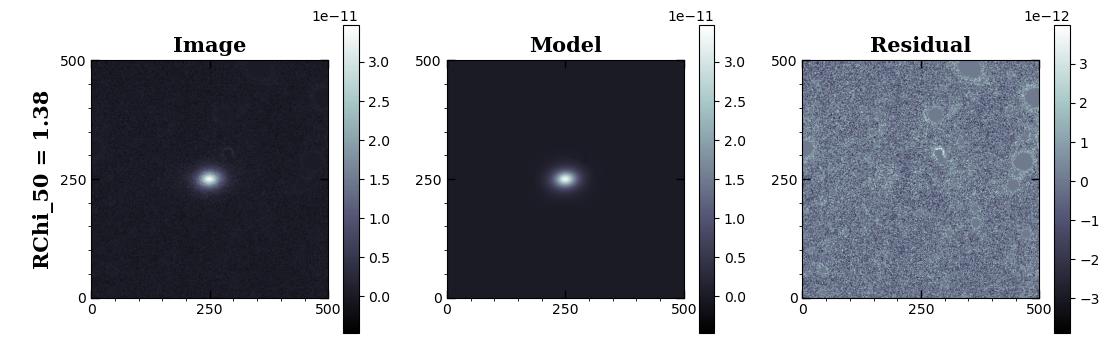

In [47]:
galid=0
ResGal=dhmc2fit.Result(MC2fitSetMain_r, RunlistMain,
                       dir_work=DI.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_hRb', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                          'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   
                   
                   
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)
ResGal.Data.fnlist

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetMain_r, fn=fn, fn_masking=DIgalfit.dir_work_list[galid]+'masking_c.fits')


## r-band with g-band parameters

In [48]:
MC2fitSetMain_g_r=dhmc2fit.Setting(plate_scale=0.2, 
                                   zeromag=0,
                                 proj_folder='galfit_g_main_r/',
                                 fni_image='image_r.fits',
                                 fni_sigma='sigma_r.fits',
                                 fni_psf='psf_r.fits',
                                 band='r',
                                )
MC2fitSetMain_g_r

Setting completed


Setting(proj_folder='galfit_g_main_r/', fn_galfit='/home/donghyeon/galfit3.0.7b/galfit', fni_image='image_r.fits', fni_psf='psf_r.fits', fni_masking='masking_c_d.fits', fni_sigma='sigma_r.fits', is_run_galfit_dir_work=False, band='r', est_sky=0, zeromag=0, plate_scale=array([0.2, 0.2]), image_size=array([500, 500]), Ncore=16, fast_skip=False, overwrite=True, remove_galfit_interval=30, debug=False, use_try=True, extract_sigma=False, output_block=True, show_progress=-1, silent=True, tolerance=0.001, comp_crit='RChi_50')

In [49]:
RunlistForRbandMain=dhmc2fit.RunlistForBest(MC2fitSetMain_g_r, RunlistMain, ResPackMain_g)
RunlistForRbandMain.Runlist_all.show_runlist()

,name,complist,ncomp,est_xpos,est_ypos,est_mag,est_reff,est_n,est_ar,est_pa,lim_xpos,lim_ypos,lim_mag,lim_reff,lim_n,lim_ar,lim_pa,use_lim,group_ID
0,rr_0,[sersic2],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(200.0 300.0),(200.0 300.0),(nan nan),(nan nan),(0.0 2.0),(0.2 1.1),(nan nan),True,0
1,rr_0w,[sersic2],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(200.0 300.0),(200.0 300.0),(nan nan),(nan nan),(0.0 2.0),(0.2 1.1),(nan nan),True,1
2,rr_1,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,10
3,rr_1w,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,11
4,rr_2,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.0 2.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,20
5,rr_2w,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.0 2.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,21
6,rr_3,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,30
7,rr_3w,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 0.0","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,31


In [50]:
RunlistForRbandMain.run_runlist(DI)



Stage 0
>> Get submodels :  0
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]

Done! | Time :  2.259016275405884
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|██████████████████████████████████| 3/3 [00:00<00:00, 54708.31it/s]

Done! | Time :  0.10565447807312012
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


Stage 1
>> Get submodels :  1
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

Done! | Time :  4.052133321762085
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|██████████████████████████████████| 3/3 [00:00<00:00, 32939.56it/s]

Done! | Time :  0.11119771003723145
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


Stage 2
>> Get submodels :  2
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]

Done! | Time :  2.494305372238159
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]

Done! | Time :  2.447608470916748
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


Stage 3
>> Get submodels :  3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]

Done! | Time :  2.5507988929748535
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|██████████████████████████████████| 3/3 [00:00<00:00, 42509.84it/s]

Done! | Time :  0.10923290252685547
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


In [51]:
## Compress
task=dhmc2fit.ExtractFits(MC2fitSetMain_g_r, DI)
dhfc.multicore_remove(DI.dir_work_list, fna=MC2fitSetMain_g_r.proj_folder+"/output*", Ncore=MC2fitSetMain_g_r.Ncore)

## Post processing
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_g_r, RunlistForRbandMain.Runlist_all, DI)
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_g_r, RunlistForRbandMain.Runlist_all, DI,
                               chi2_radius_array_set=chi_radius_array,
                               chi_item_namelist=chi_item_name_array)



# Pack
ResPackMain_g_r=dhmc2fit.ResPack(MC2fitSetMain_g_r, RunlistForRbandMain.Runlist_all, DI)
pickle.dump(ResPackMain_g_r, open(DI.dir_base+"ResPackMain_g_r.pkl", "wb"))


Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|████████████████████████████████████| 3/3 [00:00<00:00, 171.36it/s]

Done! | Time :  0.11601066589355469
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


0 / 3 | Time :  0.08394289016723633
Done! | Time :  0.1010587215423584
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [00:00<00:00, 16.23it/s]

Done! | Time :  0.28214216232299805
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:00<00:00, 19.27it/s]

Done! | Time :  0.2592506408691406
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3
Multicore run for sub_getdata with Ncore 16
show_progress :  -1
Using Try :  True



6it [00:00, 147168.56it/s]                                              

Done! | Time :  0.15416932106018066


# Test

In [ ]:
## [ADU/s]
#
#-> [ADU]  (zeromag & * exptime)

## Gain  : [e-/ADU] /1e9 


In [4]:
# data=fits.getdata('./gal_img/gal0000/image_g.fits')
# head=fits.getheader('./gal_img/gain/gal_img/gal0000/image_g.fits')
# fits.writeto('./gal_out/gal0000/image_g.fits', data, header=head,
#              overwrite=True, output_verify='silentfix')
# newgain=head['EXPTIME']*head['GAIN']/1e9
# fits.setval('./gal_out/gal0000/image_g.fits', 'GAIN', value=newgain)
# fits.setval('./gal_out/gal0000/image_g.fits', 'EXPTIME', value=1)

# data=fits.getdata('./gal_img/gal0001/image_g.fits')
# head=fits.getheader('./gal_img/gain/gal_img/gal0001/image_g.fits')
# fits.writeto('./gal_out/gal0001/image_g.fits', data, header=head,
#              overwrite=True, output_verify='silentfix')
# newgain=head['EXPTIME']*head['GAIN']/1e9
# fits.setval('./gal_out/gal0001/image_g.fits', 'GAIN', value=newgain)
# fits.setval('./gal_out/gal0001/image_g.fits', 'EXPTIME', value=1)

# data=fits.getdata('./gal_img/gal0002/image_g.fits')
# head=fits.getheader('./gal_img/gain/gal_img/gal0002/image_g.fits')
# fits.writeto('./gal_out/gal0002/image_g.fits', data, header=head,
#              overwrite=True, output_verify='silentfix')
# newgain=head['EXPTIME']*head['GAIN']/1e9
# fits.setval('./gal_out/gal0002/image_g.fits', 'GAIN', value=newgain)
# fits.setval('./gal_out/gal0002/image_g.fits', 'EXPTIME', value=1)

In [5]:
data=fits.getdata('./gal_img/gal0000/image_g.fits')
head=fits.getheader('./gal_img/current/gal0000/image_g.fits')
fits.writeto('./gal_out/gal0003/image_g.fits', data, header=head,
             overwrite=True, output_verify='silentfix')
#newgain=head['EXPTIME']*head['GAIN']/1e9
newgain=head['GAIN']/head['EXPTIME']
fits.setval('./gal_out/gal0003/image_g.fits', 'GAIN', value=newgain)
# fits.setval('./gal_out/gal0000/image_g.fits', 'EXPTIME', value=1)

data=fits.getdata('./gal_img/gal0001/image_g.fits')
head=fits.getheader('./gal_img/current/gal0001/image_g.fits')
fits.writeto('./gal_out/gal0004/image_g.fits', data, header=head,
             overwrite=True, output_verify='silentfix')
newgain=head['GAIN']/head['EXPTIME']
fits.setval('./gal_out/gal0004/image_g.fits', 'GAIN', value=newgain)
# fits.setval('./gal_out/gal0001/image_g.fits', 'EXPTIME', value=1)

data=fits.getdata('./gal_img/gal0002/image_g.fits')
head=fits.getheader('./gal_img/current/gal0002/image_g.fits')
fits.writeto('./gal_out/gal0005/image_g.fits', data, header=head,
             overwrite=True, output_verify='silentfix')
newgain=head['GAIN']/head['EXPTIME']
fits.setval('./gal_out/gal0005/image_g.fits', 'GAIN', value=newgain)
# fits.setval('./gal_out/gal0002/image_g.fits', 'EXPTIME', value=1)

In [6]:
data=fits.getdata('./gal_img/gal0000/image_g.fits')
head=fits.getheader('./gal_img/current/gal0000/image_g.fits')
fits.writeto('./gal_out/gal0006/image_g.fits', data, header=head,
             overwrite=True, output_verify='silentfix')
#newgain=head['EXPTIME']*head['GAIN']/1e9
fits.setval('./gal_out/gal0006/image_g.fits', 'NCOMBINE', value=1)
# fits.setval('./gal_out/gal0000/image_g.fits', 'EXPTIME', value=1)

data=fits.getdata('./gal_img/gal0001/image_g.fits')
head=fits.getheader('./gal_img/current/gal0001/image_g.fits')
fits.writeto('./gal_out/gal0007/image_g.fits', data, header=head,
             overwrite=True, output_verify='silentfix')
fits.setval('./gal_out/gal0007/image_g.fits', 'NCOMBINE', value=1)
# fits.setval('./gal_out/gal0001/image_g.fits', 'EXPTIME', value=1)

data=fits.getdata('./gal_img/gal0002/image_g.fits')
head=fits.getheader('./gal_img/current/gal0002/image_g.fits')
fits.writeto('./gal_out/gal0008/image_g.fits', data, header=head,
             overwrite=True, output_verify='silentfix')
fits.setval('./gal_out/gal0008/image_g.fits', 'NCOMBINE', value=1)
# fits.setval('./gal_out/gal0002/image_g.fits', 'EXPTIME', value=1)

In [17]:
fits.getheader('./gal_out/gal0000/image_g.fits')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                250.5 / Pixel coordinate of reference point            
CRPIX2  =                250.5 / Pixel coordinate of reference point            
CDELT1  =     -5.555555638E-05 / [deg] Coordinate increment at reference point  
CDELT2  =      5.555555638E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'        

In [176]:
fits.getheader('./gal_out/gal0003/image_g.fits')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                250.5 / Pixel coordinate of reference point            
CRPIX2  =                250.5 / Pixel coordinate of reference point            
CDELT1  =     -5.555555638E-05 / [deg] Coordinate increment at reference point  
CDELT2  =      5.555555638E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'        

In [38]:
sig1=fits.getdata('./gal_out/gal0000/sigma_g.fits')
sig2=fits.getdata('./gal_out/gal0003/sigma_g.fits')
sig3=fits.getdata('./gal_out/gal0006/sigma_g.fits')

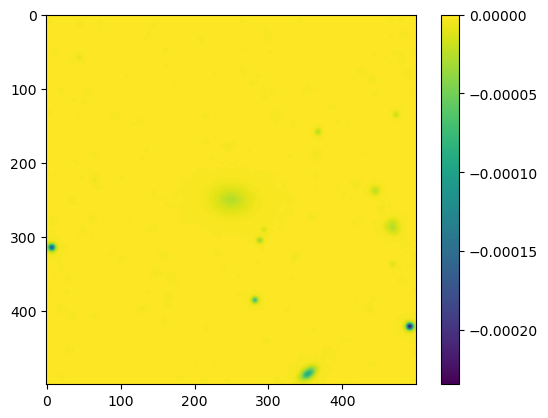

In [39]:
plt.imshow(sig1-sig2)
plt.colorbar()

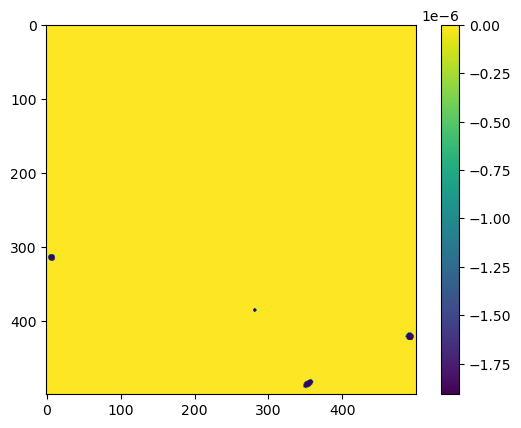

In [40]:
plt.imshow(sig1-sig3)
plt.colorbar()

## Group

In [10]:
ResPackBase_g=pickle.load(open(DI.dir_base+"ResPackBase_g.pkl", "rb"))
ResPackBase_g.preset_generate_onlyval(is_mag=False)

>> Get all submodels


In [10]:
# # If you want to remove all Galfit data, use the command below

# dhfc.multicore_remove_folder(DI.dir_work_list, Ncore=4, fna='galfit_test/', show_progress=1000,
#                             ignore_errors=True)

0 / 3 | Time :  0.023331642150878906
Done! | Time :  0.031960248947143555


In [11]:
MC2fitSetMain_test=dhmc2fit.Setting(plate_scale=0.2, 
                                    zeromag=0,
                                 proj_folder='galfit_test/',
                                 fni_image='image_g.fits',
                                 fni_sigma='sigma_g.fits',
                                 fni_psf='psf_g.fits',
                                 band='g',
                                )

Setting completed


In [12]:
## The result of the first run will be used as initial guess of the second run

est_mag_list=np.array([0]) ## No mag changes

##===========================================
## Simple Sersic (Group 0)
namelist=dharray.array_attach_string(est_mag_list, 'rs_', add_at_head=True)
# Initial guess
est_params_array=np.array([[0, 0, est_mag_list, 0, 0, 0, 0]],  ## This will be added --> All values = 0 except for est_mag.
                          dtype='object') 
    # index                      [  0   |  1   |      2     |  3 | 4 |  5   |  6 ]
    # params                    [ xpos | ypos |     mag     |reff| n |  ar  |  pa]
                # np.nan -> Default value as the initial guess
                #           xpos, ypos : center of the image
                #           ar, pa: 0
                # else -> use the given value as the initial guess

    ## Comp 1: Sky background
    ## Comp 2: Sersic in this case.

RunlistMain_sim=dhmc2fit.Runlist(MC2fitSetMain_test, namelist=namelist, complist=['sersic2'],
                             est_params_array=est_params_array,
                             group_id=0, ## Fitting group
                             size_conv=201, ## Convolution box size 
                             lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
                             lim_n=[[0, 2]],  ## Sersic index constraint (from - to)
                             lim_reff=np.nan, ## effective radii constraint (use None here) 
                             lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                            )
        
##===========================================
## PSF (Group 3)
# namelist=dharray.array_attach_string(est_mag_list, 'rpsf_', add_at_head=True)
# est_params_array=np.array([[0, 0, est_mag_list, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
#                            ],  ## New data --> values = nan (default)
#                           dtype='object') 

# RunlistMain_sim_add=dhmc2fit.Runlist(MC2fitSetMain_g, namelist=namelist, complist=['psf'],
#                                  est_params_array=est_params_array,
#                                  group_id=3, ## Fitting group
#                                  size_conv=201, ## Convolution box size 
#                                  lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
#                                  lim_n=[[0, 2]],  ## Sersic index constraint (from - to)
#                                  lim_reff=np.nan, ## effective radii constraint (use None here) 
#                                  lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
#                                 )

# RunlistMain_sim.add_runlist(RunlistMain_sim_add)


#====================================
## Variation in their magnitude

est_mag_list=np.arange(-3, 4, 3)  ## Comp2 variation
est_mag_list2=np.arange(-3, 1, 3)  ## Comp3 variation
addnamelist=['b', '0', 'd']


for i, offset in enumerate(est_mag_list):
    ## Double Sersic
    namelist=dharray.array_attach_string(est_mag_list2, 'rss_'+str(addnamelist[i])+"_", add_at_head=True)
    est_params_array=np.array([[0, 0, offset, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                               [0, 0, est_mag_list2, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                              dtype='object') 
    
    
    RunlistMain_sim_add=dhmc2fit.Runlist(MC2fitSetMain_test, namelist=namelist, complist=['sersic2','sersic2'],
                                     est_params_array=est_params_array,
                                     group_id=1, ## Fitting group
                                     size_conv=201, ## Convolution box size 
                                     lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
                                     lim_n=[[0, 2], [0.1, 5]],  ## Sersic index constraint (from - to)
                                     lim_reff=np.nan, ## effective radii constraint (use None here) 
                                     lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )
                             
    RunlistMain_sim.add_runlist(RunlistMain_sim_add)
    
    ### Different Initial Position
    if(i==0): 
        RunlistMain_pos=copy.deepcopy(RunlistMain_sim_add)
        RunlistMain_pos.runlist['group_ID']=4
        RunlistMain_pos.runlist['name']=dharray.array_attach_string(est_mag_list2, 'rssp_'+str(addnamelist[i])+"_", add_at_head=True)
    else:
        RunlistMain_pos_add=copy.deepcopy(RunlistMain_sim_add)
        RunlistMain_pos_add.runlist['group_ID']=4
        RunlistMain_pos_add.runlist['name']=dharray.array_attach_string(est_mag_list2, 'rssp_'+str(addnamelist[i])+"_", add_at_head=True)
        RunlistMain_pos.add_runlist(RunlistMain_pos_add)
        

    ##===========================================
    ## Sersic + PSF (Group 2)
    namelist=dharray.array_attach_string(est_mag_list2, 'rspsf_'+str(addnamelist[i])+"_", add_at_head=True)
    est_params_array=np.array([[0, 0, offset, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                               [0, 0, est_mag_list2, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                              dtype='object') 
    
    
    RunlistMain_sim_add=dhmc2fit.Runlist(MC2fitSetMain_test, namelist=namelist, complist=['sersic2','psf'],
                                     est_params_array=est_params_array,
                                     group_id=2, ## Fitting group
                                     size_conv=201, ## Convolution box size 
                                     lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
                                     lim_n=[[0, 2], [0.1, 5]],  ## Sersic index constraint (from - to)
                                     lim_reff=np.nan, ## effective radii constraint (use None here) 
                                     lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )
                             
    RunlistMain_sim.add_runlist(RunlistMain_sim_add)

    ### Different Initial Position
    RunlistMain_pos_add=copy.deepcopy(RunlistMain_sim_add)
    RunlistMain_pos_add.runlist['group_ID']=5
    RunlistMain_pos_add.runlist['name']=dharray.array_attach_string(est_mag_list2, 'rspsfp_'+str(addnamelist[i])+"_", add_at_head=True)
    RunlistMain_pos.add_runlist(RunlistMain_pos_add)


In [13]:
## Variation in their magnitude

est_mag_list=np.arange(-3, 4, 3)  ## Comp2 variation
est_mag_list2=np.arange(-3, 1, 3)  ## Comp3 variation
addnamelist=['b', '0', 'd']


for i, offset in enumerate(est_mag_list):
    ## Double Sersic
    namelist=dharray.array_attach_string(est_mag_list2, 'rss2_'+str(addnamelist[i])+"_", add_at_head=True)
    est_params_array=np.array([[0, 0, offset, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                               [0, 0, est_mag_list2, 5, 3, np.nan, np.nan],
                               [np.nan, np.nan, est_mag_list2, 5, 3, np.nan, np.nan]],  ## To center
                              dtype='object') 
    
    
    Runlist_Temp=dhmc2fit.Runlist(MC2fitSetMain_test, namelist=namelist, complist=['sersic2','sersic2','psf'],
                                     est_params_array=est_params_array,
                                     group_id=7, ## Fitting group
                                     size_conv=201, ## Convolution box size 
                                     lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
                                     lim_n=[[0, 2], [0.1, 5], [np.nan, np.nan]],  ## Sersic index constraint (from - to)
                                     lim_reff=np.nan, ## effective radii constraint (use None here) 
                                     lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )
                             
    
    ### Different Initial Position
    if(i==0): 
        RunlistMain_4comp=copy.deepcopy(Runlist_Temp)
    else:
        RunlistMain_4comp.add_runlist(Runlist_Temp)
        

    ##===========================================
    ## Sersic + PSF (Group 2)
    namelist=dharray.array_attach_string(est_mag_list2, 'rspsf2_'+str(addnamelist[i])+"_", add_at_head=True)
    est_params_array=np.array([[0, 0, offset, 0, 0, 0, 0],  ## This will be added --> All values = 0 except for est_mag.
                               [0, 0, est_mag_list2, 5, 3, np.nan, np.nan],
                               [np.nan, np.nan, est_mag_list2, 5, 3, np.nan, np.nan]],  ## New data --> values = nan (default)
                              dtype='object') 
    
    
    Runlist_Temp=dhmc2fit.Runlist(MC2fitSetMain_test, namelist=namelist, complist=['sersic2','psf','psf'],
                                     est_params_array=est_params_array,
                                     group_id=8, ## Fitting group
                                     size_conv=201, ## Convolution box size 
                                     lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
                                     lim_n=[[0, 2], [0.1, 5], [np.nan, np.nan]],  ## Sersic index constraint (from - to)
                                     lim_reff=np.nan, ## effective radii constraint (use None here) 
                                     lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                                )

    RunlistMain_4comp.add_runlist(Runlist_Temp)


In [14]:
RunlistMain=copy.deepcopy(RunlistMain_sim)
RunlistMain.add_runlist(RunlistMain_pos)
RunlistMain.add_runlist(RunlistMain_4comp)
RunlistMain.show_runlist()

,name,complist,ncomp,est_xpos,est_ypos,est_mag,est_reff,est_n,est_ar,est_pa,lim_xpos,lim_ypos,lim_mag,lim_reff,lim_n,lim_ar,lim_pa,use_lim,group_ID
0,rs_0,[sersic2],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(200.0 300.0),(200.0 300.0),(nan nan),(nan nan),(0.0 2.0),(0.2 1.1),(nan nan),True,0
1,rss_b_-3,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","-3.0, -3","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,1
2,rss_b_0,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","-3.0, 0.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,1
3,rspsf_b_-3,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","-3.0, -3","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
4,rspsf_b_0,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","-3.0, 0.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
5,rss_0_-3,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","0.0, -3.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,1
6,rss_0_0,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,1
7,rspsf_0_-3,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, -3.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
8,rspsf_0_0,"[sersic2, psf]",2,"0.0, 0.0","0.0, 0.0","0.0, 0.0","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,2
9,rss_d_-3,"[sersic2, sersic2]",2,"0.0, 0.0","0.0, 0.0","3.0, -3.","0.0, 5.0","0.0, 3.0","0.0, nan","0.0, nan","(200.0 300.0), (200.0 300.0)","(200.0 300.0), (200.0 300.0)","(nan nan), (nan nan)","(nan nan), (nan nan)","(0.0 2.0), (0.1 5.0)","(0.2 1.1), (0.2 1.1)","(nan nan), (nan nan)",True,1


In [15]:
UseRes=ResPackBase_g.params_array ## Shape: N_Target(DI), Comp, item (7)

UseRes_fixed_pos=np.copy(UseRes)
UseRes_fixed_pos[:,1,0]=UseRes_fixed_pos[:,0,0] 
UseRes_fixed_pos[:,1,1]=UseRes_fixed_pos[:,0,1] 
UseRes_fixed_pos[:,1,2]=0 ## mag 

In [57]:
## Run
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_test, RunlistMain_sim, DI, 
                               Ncomp_add_params_array=2, ## We will use up to 2 comp
                               add_params_array_set=UseRes_fixed_pos,  ## Measured params array
                               is_nth_mag_offset=True,
                              )

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [01:34<00:00, 31.53s/it]

Done! | Time :  94.67980623245239
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


In [58]:
maskpos=np.full((len(DIgalfit.dir_work_list), 2), np.nan)
for i in range (len(DIgalfit.dir_work_list)):
    if(i%1000==0): print(i)
    maskdat=np.load(DIgalfit.dir_work_list[i]+'maskobj_r.npy')

    try:
        maskdat=maskdat[(maskdat['x']>225) & (maskdat['y']>225) & (maskdat['x']<275) & (maskdat['y']<275)]
        dist=((maskdat['x']-250)**2+(maskdat['y']-250)**2)**0.5
        maskdat=maskdat[dist>3] ## offset
        
        thismask=maskdat[maskdat['flux']==np.nanmax(maskdat['flux'])][0]
        maskpos[i]=thismask['x'], thismask['y']
    except: pass

0


In [64]:
UseRes_newpos=np.copy(UseRes)
for i in range(len(UseRes_2nd_pos)):
    UseRes_newpos[i,1,0]=maskpos[i,0] ## X
    UseRes_newpos[i,1,1]=maskpos[i,1] ## Y
    UseRes_newpos[i,1,2]=0 ## Offset
    
newshape=np.array(np.shape(UseRes))
newshape[1]+=1 ## Ncomp ++
UseRes_4comp=np.full(newshape, np.nan)
UseRes_4comp[:,0]=np.copy(UseRes[:,0]) ## Original
UseRes_4comp[:,2]=np.copy(UseRes_newpos[:,1]) ## From above
for i in range(len(UseRes_4comp)):
    UseRes_4comp[i,1,2]=0 ## Mag Offset
    
# newshape=np.array(np.shape(UseRes))
# newshape[1]+=-1
# UseRes_2nd_psfp=np.full(newshape, np.nan)
# UseRes_2nd_psfp[:,0]=np.copy(UseRes_2nd_pos[:,1])
# UseRes_2nd_psfp[:,0,2]=np.copy(UseRes_2nd_pos[:,0,2])

In [61]:
## Run
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_test, RunlistMain_pos, DI, 
                               Ncomp_add_params_array=2, ## We will use up to 2 comp
                               add_params_array_set=UseRes_newpos,  ## Measured params array
                               is_nth_mag_offset=True,
                              )

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [02:10<00:00, 43.49s/it]

Done! | Time :  130.55810475349426
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


In [65]:
## Run
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSetMain_test, RunlistMain_4comp, DI, 
                               Ncomp_add_params_array=3, ## Updated -- We will use up to 3 comp
                               add_params_array_set=UseRes_4comp,  ## Measured params array
                               is_nth_mag_offset=True,
                              )

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [01:49<00:00, 36.37s/it]

Done! | Time :  109.2092456817627
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


In [ ]:
RunlistMain

In [ ]:
# For g-band

ResPackMain_g=dhmc2fit.ResPack(MC2fitSetMain_g, RunlistMain, DI, 
                               chi2_itemlist=['CHI2NU', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50', 
                                              'AIC_hRb', 'LIK_hRb', 'AIC_Rb', 'LIK_Rb', 
                                             ],
                               comp_crit='AIC_hRb', )
pickle.dump(ResPackMain_g, open(DI.dir_base+"ResPackMain_g.pkl", "wb"))

In [19]:
## Compress
task=dhmc2fit.ExtractFits(MC2fitSetMain_test, DI)
dhfc.multicore_remove(DI.dir_work_list, fna=MC2fitSetMain_test.proj_folder+"/output*", Ncore=MC2fitSetMain_test.Ncore)

## Post processing
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_test, RunlistMain, DI)
dhmc2fit.PostProcessing_Mulcore(MC2fitSetMain_test, RunlistMain, DI,
                               chi2_radius_array_set=chi_radius_array,
                               chi_item_namelist=chi_item_name_array)

# Pack
ResPackMainTest=dhmc2fit.ResPack(MC2fitSetMain_g, RunlistMain, DI, 
                               chi2_itemlist=['CHI2NU', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50', 
                                              'AIC_hRb', 'LIK_hRb', 'AIC_Rb', 'LIK_Rb', 
                                             ],
                               comp_crit='AIC_hRb', )
pickle.dump(ResPackMainTest, open(DI.dir_base+"ResPackMainTest.pkl", "wb"))

Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|██████████████████████████████████| 3/3 [00:00<00:00, 12029.55it/s]

Done! | Time :  0.1071314811706543
======== Multicore result ========
● Succeed: 3 / 3
● Failed: 0 / 3


0 / 3 | Time :  0.08479881286621094
Done! | Time :  0.09843564033508301
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True


100%|█████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]

Done! | Time :  1.4135856628417969
======== Multicore result ========
● Succeed: 0 / 3
● Failed: 3 / 3
>> See where: self.multi_res
>> To debug, use Ncore=1, and use_try = False
Multicore run for sub_run_process with Ncore 16
show_progress :  -1
Using Try :  True



100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s]

Done! | Time :  1.017014741897583
======== Multicore result ========
● Succeed: 0 / 3
● Failed: 3 / 3
>> See where: self.multi_res
>> To debug, use Ncore=1, and use_try = False
Multicore run for sub_getdata with Ncore 16
show_progress :  -1
Using Try :  True



6it [00:00, 118149.41it/s]                                              

Done! | Time :  0.1161346435546875


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_MAG,3_XC,3_YC,3_MU_E,3_RE,3_N,3_MAG,4_XC,4_YC,4_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,261.430500,254.155300,25.162600,90.418700,1.023700,16.871300,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.719889,0.719889,165868.239120,1.000000,1.272678,9820.730469,0.000000,23689.688507,1.000000,8877.533124,0.000000
rss_b_-3,1.000000,0.000000,261.500000,254.051900,25.114500,88.959600,0.909000,16.922100,261.046700,255.522100,22.306700,2.202700,2.551400,21.165400,nan,nan,nan,0.708388,0.708388,163227.765516,1.000000,0.889184,6874.110626,1.000000,20694.963105,1.000000,5906.165862,0.998940
rss_b_0,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rspsf_b_-3,2.000000,0.000000,261.490300,254.041500,25.121300,89.206200,0.914600,16.920700,261.145300,255.534400,nan,nan,nan,20.836300,nan,nan,nan,0.708571,0.708571,163264.677082,1.000000,0.891692,6888.953072,1.000000,20757.602780,1.000000,5903.288365,0.998897
rspsf_b_0,2.000000,0.000000,261.499000,254.464700,25.158500,90.377500,1.006800,16.878300,257.795700,239.233600,nan,nan,nan,23.619000,nan,nan,nan,0.713472,0.713472,164393.873094,1.000000,1.079197,8332.927655,0.000001,22156.267858,1.000000,7386.265202,0.000000
rss_0_-3,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rss_0_0,1.000000,0.000000,261.529800,254.111100,25.127800,89.666600,0.900100,16.931300,260.896300,255.248900,25.198000,9.922000,5.000000,20.971800,nan,nan,nan,0.708949,0.708949,163357.036401,1.000000,0.900747,6963.108578,1.000000,20825.881150,1.000000,6008.928483,0.983060
rspsf_0_-3,2.000000,0.000000,261.490400,254.041500,25.121300,89.206300,0.914600,16.920700,261.144700,255.534400,nan,nan,nan,20.836300,nan,nan,nan,0.708571,0.708571,163264.679753,1.000000,0.891695,6888.974525,1.000000,20757.646398,1.000000,5903.301107,0.998897
rspsf_0_0,2.000000,0.000000,261.490100,254.041500,25.121300,89.206000,0.914600,16.920700,261.146700,255.534300,nan,nan,nan,20.836400,nan,nan,nan,0.708571,0.708571,163264.674459,1.000000,0.891687,6888.915528,1.000000,20757.544444,1.000000,5903.250091,0.998898
rss_d_-3,1.000000,0.000000,261.482500,255.710100,25.658900,103.170700,0.972000,17.276200,260.808300,250.591600,26.060000,79.276000,1.002100,18.124600,nan,nan,nan,0.711661,0.711661,163981.640955,1.000000,1.231495,9508.882088,0.000000,23092.793766,1.000000,8582.808387,0.000000


,group_ID,is_swap,2_XC,2_YC,2_MU_E,2_RE,2_N,2_AR,2_PA,2_MAG,3_XC,3_YC,3_MU_E,3_RE,3_N,3_AR,3_PA,3_MAG,4_XC,4_YC,4_MAG,CHI2NU,RChi_F,AIC_F,LIK_F,RChi_50,AIC_50,LIK_50,AIC_Rb,LIK_Rb,AIC_hRb,LIK_hRb
rs_0,0.000000,0.000000,261.430500,254.155300,25.162600,90.418700,1.023700,0.525100,-54.881400,16.871300,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.719889,0.719889,165868.239120,1.000000,1.272678,9820.730469,0.000000,23689.688507,1.000000,8877.533124,0.000000
rss_b_-3,1.000000,0.000000,261.500000,254.051900,25.114500,88.959600,0.909000,0.521000,-54.913600,16.922100,261.046700,255.522100,22.306700,2.202700,2.551400,0.806300,9.747800,21.165400,nan,nan,nan,0.708388,0.708388,163227.765516,1.000000,0.889184,6874.110626,1.000000,20694.963105,1.000000,5906.165862,0.998940
rspsf_0_0,2.000000,0.000000,261.490100,254.041500,25.121300,89.206000,0.914600,0.520700,-54.912800,16.920700,261.146700,255.534300,nan,nan,nan,nan,nan,20.836400,nan,nan,nan,0.708571,0.708571,163264.674459,1.000000,0.891687,6888.915528,1.000000,20757.544444,1.000000,5903.250091,0.998898
rssp_0_0,4.000000,0.000000,261.484400,254.045200,25.114700,88.859200,0.920300,0.522200,-54.884500,16.916600,261.056600,255.595900,23.106900,4.309400,0.100000,0.959300,62.551900,21.460500,nan,nan,nan,0.707954,0.707954,163127.692237,1.000000,0.884520,6838.215849,1.000000,20651.988635,1.000000,5876.607178,0.999594
rspsfp_0_-3,5.000000,0.000000,261.489800,254.041500,25.121300,89.206000,0.914600,0.520700,-54.912800,16.920700,261.148200,255.534300,nan,nan,nan,nan,nan,20.836400,nan,nan,nan,0.708571,0.708571,163264.676582,1.000000,0.891681,6888.867285,1.000000,20757.486709,1.000000,5903.212749,0.998900
rss2_b_0,7.000000,0.000000,261.554900,254.376500,25.108600,88.775100,0.896400,0.521100,-54.998800,16.926900,261.113400,255.635600,22.906700,4.211000,0.100000,0.931100,75.847800,21.342900,257.689300,239.187800,23.488800,0.699888,0.699888,161273.494267,1.000000,0.626093,4853.245291,1.000000,18652.027089,1.000000,3885.845678,1.000000
rspsf2_0_-3,8.000000,1.000000,261.554000,254.372100,25.115900,89.146600,0.891900,0.519600,-55.027200,16.930600,261.233100,255.562400,nan,nan,nan,nan,nan,20.773900,257.683200,239.149500,23.502700,0.700680,0.700680,161450.745943,1.000000,0.638413,4942.560093,1.000000,18802.598029,1.000000,3949.480225,1.000000


./gal_out/gal0002/galfit_test/result_rss2_b_0.fits


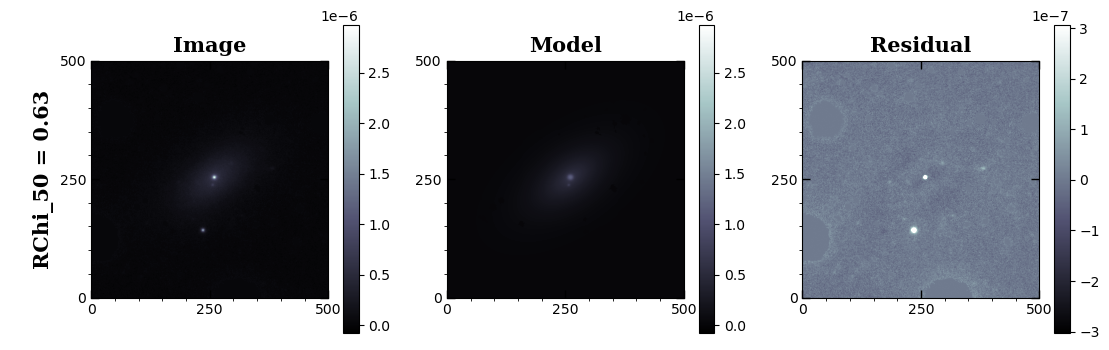

In [16]:
### Exp time -> 1

galid=2
ResGal=dhmc2fit.Result(MC2fitSetMain_test, RunlistMain,
                       dir_work=DI.dir_work_list[galid],
                       group_id=None, 
                       comp_crit='AIC_hRb', 
                       chi2_itemlist=['CHI2NU', 'RChi_F', 'AIC_F', 'LIK_F', 'RChi_50', 'AIC_50', 'LIK_50',
                                    'AIC_Rb', 'LIK_Rb', 'AIC_hRb', 'LIK_hRb'
                                           ], 
                   )
ResGal.show_data(only_val=True, hide_PA=True, hide_fail_read=False)

ResBest=dhmc2fit.ResultBest(ResGal, include_warn=True, get_single=True)
ResBest.show_data(only_val=True, hide_PA=False)

fn=ResGal.Data.fnlist[ResGal.best_warn[0]]
print(fn)


img=dhmc2fit.Drawing(MC2fitSetMain_test, fn=fn, fn_masking=DIgalfit.dir_work_list[galid]+'masking_c.fits')